In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Setting():
	def __init__(self, x_size=4, y_size=12, a_size=4, start=(3, 0), goal=(3, 11)):
		self.x_size = x_size
		self.y_size = y_size
		self.a_size = a_size
		self.start = start # x, y
		self.goal = goal   # x, y
		self.cliff = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[3,9],[3,10]]

In [ ]:
class GridWorld():
  def __init__(self, setting: Setting):
    self.setting = setting
    self.x, self.y = setting.start
    self.cliff = setting.cliff

  def step(self, a):
    if a==0:
      self.move_right()
    elif a==1:
      self.move_left()
    elif a==2:
      self.move_up()
    elif a==3:
      self.move_down()
    elif a==4:
      self.move_right_up()
    elif a==5:
      self.move_left_down()
    elif a==6:
      self.move_left_up()
    elif a==7:
      self.move_right_down()
    if [self.x, self.y] in self.cliff:
      reward = -100
      self.x, self.y = self.setting.start
    else:
      reward = -1
    done = self.is_done()
    return (self.x, self.y), reward, done

  def move_right(self):
    self.y += 1
    if self.y > self.setting.y_size-1:
      self.y = self.setting.y_size-1

  def move_left(self):
    self.y -= 1
    if self.y < 0:
      self.y = 0

  def move_up(self):
    self.x -= 1
    if self.x < 0:
      self.x = 0

  def move_down(self):
    self.x += 1
    if self.x > self.setting.x_size-1:
      self.x = self.setting.x_size-1

  def move_right_up(self):
    x = self.x - 1
    y = self.y + 1
    if x < 0 or y > self.setting.y_size-1:
      return
    self.x = x
    self.y = y

  def move_left_down(self):
    x = self.x + 1
    y = self.y - 1
    if x > self.setting.x_size-1 or y < 0:
      return
    self.x = x
    self.y = y

  def move_left_up(self):
    x = self.x - 1
    y = self.y - 1
    if x < 0 or y < 0:
      return
    self.x = x
    self.y = y

  def move_right_down(self):
    x = self.x + 1
    y = self.y + 1
    if x > self.setting.x_size-1 or y > self.setting.y_size-1:
      return
    self.x = x
    self.y = y

  def is_done(self):
    if (self.x, self.y) == self.setting.goal:
      return True
    else:
      return False

  def get_state(self):
    return (self.x, self.y)

  def reset(self):
    self.x, self.y = self.setting.start
    return (self.x, self.y)


In [4]:
class AgentMC():
  def __init__(self, setting: Setting):
    self.setting = setting
    self.q_table = np.zeros((setting.x_size, setting.y_size, setting.a_size)) # x size, y size, number of action
    self.eps = 0.9
    self.alpha = 0.01

  def select_action(self, s):
    # epsilon-soft greedy policy
    x, y = s
    prob =  random.random()
    if prob < self.eps: # perform random action with epsilon probabilty
      action = random.randint(0, self.setting.a_size-1)
    else: # greedy
      action_val = self.q_table[x,y,:]
      action = np.argmax(action_val)
    return action

  def update_table(self, history):
    # history is all visited states during one episode
    cum_reward = 0
    for transition in history[::-1]:
      s,a,r,s_next = transition
      x,y = s
      # Monte-Carlo Predition to estimate Q(s,a) (nothing but an alternative expression of V(s))
      self.q_table[x,y,a] = (1-self.alpha)*self.q_table[x,y,a] + self.alpha * cum_reward # Now, I think you are familiar with Robbins-Monro form
      # self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha * (cum_reward - self.q_table[x,y,a])
      cum_reward = cum_reward + r

  def anneal_eps(self):
    # annealing part: You may safely ignore this part :) (by Han)
    self.eps -= 0.03
    self.eps = max(self.eps, 0.1)

  def show_table(self):
    # Show me the one action of which results in the best Q(s,a) value
    q_list = self.q_table.tolist()
    best_qvalue = np.zeros((self.setting.x_size, self.setting.y_size))
    best_action = np.zeros((self.setting.x_size, self.setting.y_size))
    for row_idx in range(len(q_list)):
      row = q_list[row_idx]
      for col_idx in range(len(row)):
        col = row[col_idx]
        qvalue = np.max(col)
        action = np.argmax(col)
        best_qvalue[row_idx, col_idx] = qvalue
        best_action[row_idx, col_idx] = action
    return best_qvalue, best_action

In [5]:
def main(setting: Setting):
  env = GridWorld(setting)
  agent = AgentMC(setting)

  for n_epi in range(5000):
    done = False
    history = []

    s = env.reset()
    while not done:
      a = agent.select_action(s)
      s_next, r, done = env.step(a)
      history.append((s,a,r,s_next))
      s = s_next
    agent.update_table(history)
    agent.anneal_eps()

  # Show me the result when it has done!
  opt_q, opt_policy = agent.show_table()

   # Display the opt_q
  fig, ax = plt.subplots()
  plt.imshow(opt_policy, cmap='cool', interpolation='nearest')
  for i in range(setting.x_size):
    for j in range(setting.y_size):
        tempstr = "{:.1f}".format(opt_q[i][j])
        text = ax.text(j, i, tempstr, ha="center", va="center", color="k")
  plt.show()

  # Display the opt_policy
  # 0:R, 1:L, 2:U, 3:D
  # 0:→, 1:←, 2:↑, 3:↓
  fig, ax = plt.subplots()
  plt.imshow(opt_policy, cmap='cool', interpolation='nearest')
  for i in range(setting.x_size):
    for j in range(setting.y_size):
        if opt_policy[i][j] == 0:
            tempstr = "→"
        elif opt_policy[i][j] == 1:
            tempstr = "←"
        elif opt_policy[i][j] == 2:
            tempstr = "↑"
        elif opt_policy[i][j] == 3:
            tempstr = "↓"
        elif opt_policy[i][j] == 4:
            tempstr = "↗"
        elif opt_policy[i][j] == 5:
            tempstr = "↙"
        elif opt_policy[i][j] == 6:
            tempstr = "↖"
        elif opt_policy[i][j] == 7:
            tempstr = "↘"
        text = ax.text(j, i, tempstr, ha="center", va="center", color="k")
  plt.show()


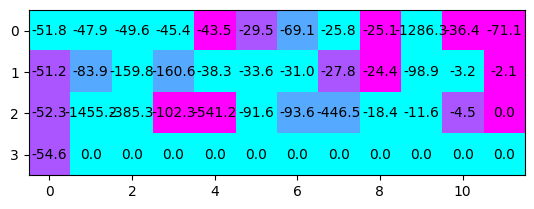

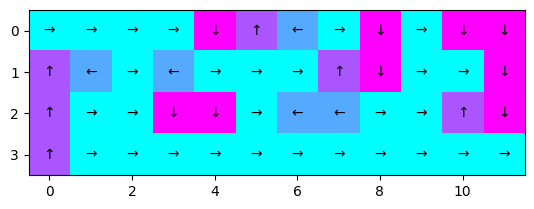

In [6]:
# case a
setting = Setting()
main(setting)

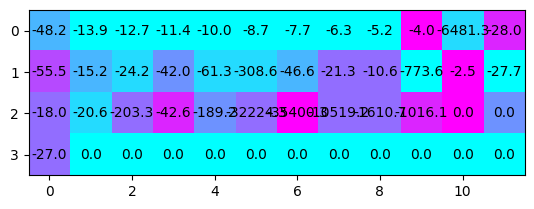

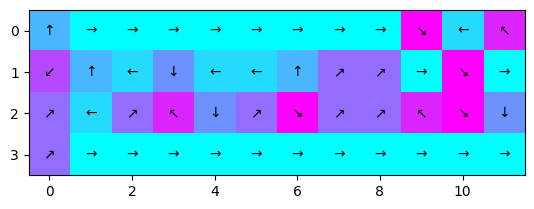

In [7]:
# case b
setting = Setting(a_size=8)
main(setting)